In [1]:
TARGET_NODE = 151

probe_sample = 80

TARGET_STR = str(TARGET_NODE)

import argparse
import traceback
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_info
import models
import tasks
import utils.callbacks
import utils.data
import utils.email
import utils.logging
import torch
from matplotlib import pyplot as plt
import networkx as nx
import math
import time
import torch
import numpy as np
import pandas as pd
from scipy.special import softmax
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.inference import VariableElimination
from scipy import stats

from pgmpy.estimators import HillClimbSearch, BicScore

def graph_from_adj(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    return gr
class Node_Explainer:
    def __init__(
        self,
        model,
        regressor,
        A,
        X,
        target,
        num_layers,
        mode = 0,
        print_result = 1
    ):
        self.model = model
        self.model.eval()
        self.regressor = regressor
        self.A = A
        self.X = X
        self.target = target
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result
        print("Explainer settings")
        print("\\ A dim: ", self.A.shape)
        print("\\ X dim: ", self.X.shape)
        print("\\ Number of layers: ", self.num_layers)
        print("\\ Perturbation mode: ", self.mode)
        print("\\ Print result: ", self.print_result)
    
    def n_hops_A(self, n_hops):
        # Compute the n-hops adjacency matrix
        adj = torch.tensor(self.A, dtype=torch.float)
        hop_adj = power_adj = adj
        for i in range(n_hops - 1):
            power_adj = power_adj @ adj
            prev_hop_adj = hop_adj
            hop_adj = hop_adj + power_adj
            hop_adj = (hop_adj > 0).float()
        return hop_adj.numpy().astype(int)
    
    def extract_n_hops_neighbors(self, nA, node_idx):
        # Return the n-hops neighbors of a node
        node_nA_row = nA[node_idx]
        neighbors = np.nonzero(node_nA_row)[0]
        node_idx_new = sum(node_nA_row[:node_idx])
        sub_A = self.A[neighbors][:, neighbors]
        sub_X = self.X[neighbors]
        return node_idx_new, sub_A, sub_X, neighbors
    
    def perturb_features_on_node_1d(self, feature_matrix, node_idx, random = 0, mode = 0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature
        
        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size = 1)
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx], np.random.uniform(low=0.0, high=2.0, size = 1))
            X_perturb[node_idx] = perturb_array
        return X_perturb
    
    def perturb_features_on_node(self,feature_matrix, node_idx, random = 0, mode = 0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature
        
        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size = X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],np.random.uniform(low=0.0, high=2.0, size = X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb
    
    def generalize_target(self, x):
        if x > 10:
            return x - 10
        else:
            return x

    def generalize_others(self, x):
        if x == 2:
            return 1
        elif x == 12:
            return 11
        else:
            return x

    def generate_evidence(self, evidence_list):
        return dict(zip(evidence_list,[1 for node in evidence_list]))
    
    def chi_square(self, X, Y, Z, data):
        """
        Modification of Chi-square conditional independence test from pgmpy
        Tests the null hypothesis that X is independent from Y given Zs.
        Parameters
        ----------
        X: int, string, hashable object
            A variable name contained in the data set
        Y: int, string, hashable object
            A variable name contained in the data set, different from X
        Zs: list of variable names
            A list of variable names contained in the data set, different from X and Y.
            This is the separating set that (potentially) makes X and Y independent.
            Default: []
        Returns
        -------
        chi2: float
            The chi2 test statistic.
        p_value: float
            The p_value, i.e. the probability of observing the computed chi2
            statistic (or an even higher value), given the null hypothesis
            that X _|_ Y | Zs.
        sufficient_data: bool
            A flag that indicates if the sample size is considered sufficient.
            As in [4], require at least 5 samples per parameter (on average).
            That is, the size of the data set must be greater than
            `5 * (c(X) - 1) * (c(Y) - 1) * prod([c(Z) for Z in Zs])`
            (c() denotes the variable cardinality).
        References
        ----------
        [1] Koller & Friedman, Probabilistic Graphical Models - Principles and Techniques, 2009
        Section 18.2.2.3 (page 789)
        [2] Neapolitan, Learning Bayesian Networks, Section 10.3 (page 600ff)
            http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks(Neapolitan,%20Richard).pdf
        [3] Chi-square test https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Test_of_independence
        [4] Tsamardinos et al., The max-min hill-climbing BN structure learning algorithm, 2005, Section 4
        """
        if isinstance(X, int):
            X = str(int(X))
        if isinstance(Y, int):
            Y = str(int(Y))
        if isinstance(Z, (frozenset, list, set, tuple)):
            Z = list(Z)        
        Z = [str(int(z)) for z in Z]
            
        state_names = {
            var_name: data.loc[:, var_name].unique() for var_name in data.columns
        }
        
        row_index = state_names[X]
        column_index = pd.MultiIndex.from_product(
                [state_names[Y]] + [state_names[z] for z in Z], names=[Y] + Z
            )
        
        XYZ_state_counts = pd.crosstab(
                    index=data[X], columns= [data[Y]] + [data[z] for z in Z],
                    rownames=[X], colnames=[Y] + Z
                )

        if not isinstance(XYZ_state_counts.columns, pd.MultiIndex):
                XYZ_state_counts.columns = pd.MultiIndex.from_arrays([XYZ_state_counts.columns])
        XYZ_state_counts = XYZ_state_counts.reindex(
                index=row_index, columns=column_index
            ).fillna(0)
        
        if Z:
            XZ_state_counts = XYZ_state_counts.sum(axis=1,level = list( range(1,len(Z)+1)) )  # marginalize out Y
            YZ_state_counts = XYZ_state_counts.sum().unstack(Z)  # marginalize out X
        else:
            XZ_state_counts = XYZ_state_counts.sum(axis=1)
            YZ_state_counts = XYZ_state_counts.sum()
        Z_state_counts = YZ_state_counts.sum()  # marginalize out both
        
        XYZ_expected = np.zeros(XYZ_state_counts.shape)

        r_index = 0
        for X_val in XYZ_state_counts.index:
            X_val_array = []
            if Z:
                for Y_val in XYZ_state_counts.columns.levels[0]:
                    temp = XZ_state_counts.loc[X_val] * YZ_state_counts.loc[Y_val] / Z_state_counts
                    X_val_array = X_val_array + list(temp.to_numpy())
                XYZ_expected[r_index] = np.asarray(X_val_array)
                r_index=+1
            else:
                for Y_val in XYZ_state_counts.columns:
                    temp = XZ_state_counts.loc[X_val] * YZ_state_counts.loc[Y_val] / Z_state_counts
                    X_val_array = X_val_array + [temp]
                XYZ_expected[r_index] = np.asarray(X_val_array)
                r_index=+1
        
        observed = XYZ_state_counts.to_numpy().reshape(1,-1)
        expected = XYZ_expected.reshape(1,-1)
        observed, expected = zip(*((o, e) for o, e in zip(observed[0], expected[0]) if not (e == 0 or math.isnan(e) )))
        chi2, significance_level = stats.chisquare(observed, expected)

        return chi2, significance_level
    
    def explain_tgcn_node(self, 
                          node_idx, 
                          pred_threshold = 0.01, 
                          p_omega = 0.5,   # 
                          num_perturbations = 100, 
                          p_threshold = 0.01 ):
        
#           node_idx:  node to explain
#           pred_threshold: change in the softmax 
#           p_omega: perturbation probability // node , 0.2, 0.1, 
#           num_perturbations: number of perturbations  // larger 
#           p_threshold: p values for dependent neighbors  // 
        
        nA = self.n_hops_A(self.num_layers)
        node_idx_new, sub_A, sub_X, neighbors = self.extract_n_hops_neighbors(nA,node_idx)
        pred_output, _ = self.model.forward(self.X.unsqueeze(0))
        pred_output = pred_output.reshape((1, self.X.shape[0], -1))
        soft_pred = self.regressor.forward(pred_output)[0,:,self.target]

        Samples = []
        Pred_Samples = []
        
        pred_omega = int(1/p_omega)

        for iteration in range(num_perturbations):
            X_perturb = self.X.cpu().detach().numpy().copy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(pred_omega)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node_1d(X_perturb, node, random = seed, mode = 1)
                else:
                    latent = 0
                sample.append(latent)
            X_perturb_torch =  torch.tensor([X_perturb], dtype=torch.float)
            pred_perturb_torch, _ = self.model.forward(X_perturb_torch)
            pred_perturb_torch = pred_perturb_torch.reshape((1, self.X.shape[0], -1))
            soft_pred_perturb = self.regressor.forward(pred_perturb_torch)[0,:,self.target]
            sample_bool = []
            for node in neighbors:
#                 print("node: ", node)
#                 print("soft_pred_perturb[node]", soft_pred_perturb[node].item())
#                 print("soft_pred[node]", soft_pred[node].item())

#                 if node == node_idx:
#                     if torch.abs(soft_pred_perturb[node] - soft_pred[node]).item() > pred_threshold:
#                         sample_bool.append(1)
#                     else:
#                         sample_bool.append(0)
#                 else:
#                     sample_bool.append(0)
                    
                if torch.abs(soft_pred_perturb[node] - soft_pred[node]).item() > pred_threshold:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)
            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples-Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray([Samples[s,i]*10 + Pred_Samples[s,i]+1 for i in range(Samples.shape[1])])

        data = pd.DataFrame(Combine_Samples)
        data.columns = ['var_' + str(col) for col in data.columns]
        ind_sub_to_ori = dict(zip(list(data.columns), neighbors))
        ind_ori_to_sub = dict(zip(neighbors,list(data.columns)))
        
        p_values = []
        dependent_neighbors = []
        dependent_neighbors_p_values = []
        for node in neighbors:
            chi2, p = self.chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data)
            p_values.append(p)
            if p < p_threshold:
                dependent_neighbors.append(node)
                dependent_neighbors_p_values.append(p)
        
        pgm_stats = dict(zip(neighbors,p_values))
        
        if dependent_neighbors == [node_idx]:
            buff_stats = pgm_stats.copy()
            del buff_stats[node_idx]
            most_dependent_neighbor = min(buff_stats, key=buff_stats.get)#the key of buff_stats that has the smallest value
            dependent_neighbors.append(most_dependent_neighbor)
            print("!!!", dependent_neighbors)
        
        pgm_nodes = dependent_neighbors
        
        data = data.rename(columns={"A": 0, "B": 1})
        data = data.rename(columns=ind_sub_to_ori)
        
        return pgm_nodes, data, pgm_stats
    
    def pgm_generate(self, target, data, pgm_stats, subnodes, child = None):
   
        subnodes = [str(int(node)) for node in subnodes]
        target = str(int(target))
        subnodes_no_target = [node for node in subnodes if node != target]
        data.columns = data.columns.astype(str)
        
        MK_blanket = self.search_MK(data, target, subnodes_no_target.copy())
        

        if child == None:
#             est = HillClimbSearch(data[subnodes_no_target], scoring_method=BicScore(data))
            est = HillClimbSearch(data[subnodes_no_target])
            pgm_no_target = est.estimate(scoring_method=BicScore(data))
            for node in MK_blanket:
                if node != target:
                    pgm_no_target.add_edge(node,target)

        #   Create the pgm    
            pgm_explanation = BayesianModel()
            for node in pgm_no_target.nodes():
                pgm_explanation.add_node(node)
            for edge in pgm_no_target.edges():
                pgm_explanation.add_edge(edge[0],edge[1])
            if target not in list(pgm_explanation.nodes):
                pgm_explanation.add_node(target)

        #   Fit the pgm
            data_ex = data[subnodes].copy()
            data_ex[target] = data[target].apply(self.generalize_target)
            for node in subnodes_no_target:
                data_ex[node] = data[node].apply(self.generalize_others)
            pgm_explanation.fit(data_ex)
        else:
            data_ex = data[subnodes].copy()
            data_ex[target] = data[target].apply(self.generalize_target)
            for node in subnodes_no_target:
                data_ex[node] = data[node].apply(self.generalize_others)
                
#             est = HillClimbSearch(data_ex, scoring_method=BicScore(data_ex))
            est = HillClimbSearch(data_ex)
            pgm_w_target_explanation = est.estimate(scoring_method=BicScore(data))
            
            #   Create the pgm    
            pgm_explanation = BayesianModel()
            for node in pgm_no_target.nodes():
                pgm_explanation.add_node(node)
            for edge in pgm_no_target.edges():
                pgm_explanation.add_edge(edge[0],edge[1])
            if target not in list(pgm_explanation.nodes):
                pgm_explanation.add_node(target)

            #   Fit the pgm
            data_ex = data[subnodes].copy()
            data_ex[target] = data[target].apply(self.generalize_target)
            for node in subnodes_no_target:
                data_ex[node] = data[node].apply(self.generalize_others)
            pgm_explanation.fit(data_ex)
        
        return pgm_explanation
    
    def search_MK(self, data, target, nodes):
        target = str(int(target))
        data.columns = data.columns.astype(str)
        nodes = [str(int(node)) for node in nodes]
        
        MB = nodes
        while True:
            if MB == []:
                return MB
            count = 0
            for node in nodes:
                evidences = MB.copy()
                evidences.remove(node)
                if target not in nodes:
                    _, p = self.chi_square(target, node, evidences, data[nodes + [target]])
                else:
                    _, p = self.chi_square(target, node, evidences, data[nodes])
                if p > 0.05:
                    MB.remove(node)
                    count = 0
                else:
                    count = count + 1
                    if count == len(MB):
                        return MB
    
    def generate_evidence(self, evidence_list):
        return dict(zip(evidence_list, [1 for node in evidence_list]))
                    
    def pgm_conditional_prob(self, target, pgm_explanation, evidence_list):
        pgm_infer = VariableElimination(pgm_explanation)
        for node in evidence_list:
            if node not in list(pgm_infer.model.nodes):
                print("Not valid evidence list.")
                return None
        evidences = self.generate_evidence(evidence_list)
        elimination_order = [node for node in list(pgm_infer.model.nodes) if node not in evidence_list]
        elimination_order = [node for node in elimination_order if node != target]
        q = pgm_infer.query([target], evidence = evidences,
                        elimination_order = elimination_order, show_progress=False)
        return q.values[0]

ModuleNotFoundError: No module named 'models'

In [ ]:

DATA_PATHS = {
    "shenzhen": {"feat": "data/sz_speed.csv", "adj": "data/sz_adj.csv"},
    "losloop": {"feat": "data/los_speed.csv", "adj": "data/los_adj.csv"},
}


def get_model(args, dm):
    model = None
    if args.model_name == "GCN":
        model = models.GCN(adj=dm.adj, input_dim=args.seq_len, output_dim=args.hidden_dim)
    if args.model_name == "GRU":
        model = models.GRU(input_dim=dm.adj.shape[0], hidden_dim=args.hidden_dim)
    if args.model_name == "TGCN":
        model = models.TGCN(adj=dm.adj, hidden_dim=args.hidden_dim)
    return model


def get_task(args, model, dm):
    task = getattr(tasks, args.settings.capitalize() + "ForecastTask")(
        model=model, feat_max_val=dm.feat_max_val, **vars(args)
    )
    return task


def get_callbacks(args):
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="train_loss")
    plot_validation_predictions_callback = utils.callbacks.PlotValidationPredictionsCallback(monitor="train_loss")
    callbacks = [
        checkpoint_callback,
        plot_validation_predictions_callback,
    ]
    return callbacks


def main_supervised(args):
    dm = utils.data.SpatioTemporalCSVDataModule(
        feat_path=DATA_PATHS[args.data]["feat"], adj_path=DATA_PATHS[args.data]["adj"], **vars(args)
    )
    model = get_model(args, dm)
    task = get_task(args, model, dm)
    callbacks = get_callbacks(args)
    trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks)
    trainer.fit(task, dm)
    results = trainer.validate(datamodule=dm)
    return results, model,task, dm  


def main(args):
    rank_zero_info(vars(args))
    results, model,task, dm = globals()["main_" + args.settings](args)
    return results, model,task, dm

In [ ]:
parser = argparse.ArgumentParser()
#parser = pl.Trainer.add_argparse_args(parser)

parser.add_argument("--max_epochs", default = 10)
parser.add_argument("--pre_len", type=int, default=3)
parser.add_argument("--val_batch_size", type=int, default=1)
#parser.add_argument("--learning_rate", default = 0.001)
#parser.add_argument("--weight_decay", default = 0)
#parser.add_argument("--batch_size", default =  32)
#parser.add_argument("--hidden_dim", default = 64)
#parser.add_argument("--loss", default = "mse_with_regularizer") 
parser.add_argument("--gpus", default =  1) 


parser.add_argument(
    "--data", type=str, help="The name of the dataset", choices=("shenzhen", "losloop"), default="shenzhen"
)
parser.add_argument(
    "--model_name",
    type=str,
    help="The name of the model for spatiotemporal prediction",
    choices=("GCN", "GRU", "TGCN"),
    default="TGCN",
)
parser.add_argument(
    "--settings",
    type=str,
    help="The type of settings, e.g. supervised learning",
    choices=("supervised",),
    default="supervised",
)
parser.add_argument("--log_path", type=str, default=None, help="Path to the output console log file")
parser.add_argument("--send_email", "--email", action="store_true", help="Send email when finished")

temp_args, _ = parser.parse_known_args()

parser = getattr(utils.data, temp_args.settings.capitalize() + "DataModule").add_data_specific_arguments(parser)
parser = getattr(models, temp_args.model_name).add_model_specific_arguments(parser)
parser = getattr(tasks, temp_args.settings.capitalize() + "ForecastTask").add_task_specific_arguments(parser)

args = parser.parse_args("")
utils.logging.format_logger(pl._logger)
if args.log_path is not None:
    utils.logging.output_logger_to_file(pl._logger, args.log_path)

rank_zero_info(vars(args))
dm = utils.data.SpatioTemporalCSVDataModule(
    feat_path=DATA_PATHS[args.data]["feat"], adj_path=DATA_PATHS[args.data]["adj"], **vars(args)
)
model = get_model(args, dm)
task = get_task(args, model, dm)
callbacks = get_callbacks(args)
path = "model_tgcn.pt"
task.load_state_dict(torch.load(path))

dm.setup() # Generate train/val dataset
#results, model, task, dm = main(args)

# trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks)
# results = trainer.validate(task, datamodule=dm)

In [ ]:
#Clone regressor
#source_task: contain attributes model (TGCN) and regressor
#dest_task: clone only regressor part. 

dest_task = tasks.supervised.SupervisedForecastTask_clone(hidden_dim = args.hidden_dim)
source_task = task

task_clone_layers = []
for item in dest_task._modules.items():
    task_clone_layers.append(item[0])
    
source_task.eval()
dest_task.eval()
for layer in task_clone_layers: 
    if layer == "regressor":
        if hasattr(getattr(dest_task, layer), 'weight'):
            with torch.no_grad():
                getattr(dest_task, layer).weight.copy_(getattr(source_task, layer).weight)
        if hasattr(getattr(dest_task, layer), 'bias'):
            with torch.no_grad():
                getattr(dest_task, layer).bias.copy_(getattr(source_task, layer).bias)

adj = dm._adj # adjacent matrix for GCN
input_dim =  adj.shape[0] 
hidden_dim = args.hidden_dim # RNN hidden state dimension

source_model = source_task.model.tgcn_cell # source model we need to clone 
source_model.eval()

# Taking the sample and the model out


First save data in all time slots

In [6]:

samples = 0
#threshold = 581 
end = 581
start = end - 96  + 1
# end = 535
# start = 529

for val_features, val_labels in dm.val_dataloader():
    samples = samples + 1
    
    if samples >= start and samples<=end:
        print(samples)
        #print("node: ", i)
        inputs = val_features
        batch_size, seq_len, num_nodes = inputs.shape
        assert input_dim == num_nodes

        dependent_neighbors = []
        for probe_snapshot in range(11,12):

            hidden_state = torch.zeros(batch_size, num_nodes * hidden_dim).type_as(inputs)
            output = None
            for i in range(probe_snapshot):
                if i == probe_snapshot - 1:
                    dest_model = models.tgcn.TGCNCell_clone(adj, input_dim, hidden_dim, hidden_state)
                    dest_model.eval()    
                    clone_layers = []
                    for item in source_task.model.tgcn_cell._modules.items():
                        clone_layers.append(item[0])

                    for layer in clone_layers:
                        if hasattr(getattr(dest_model, layer), 'weights'):
                            with torch.no_grad():
                                getattr(dest_model, layer).weights.copy_(getattr(source_model, layer).weights)
                        if hasattr(getattr(dest_model, layer), 'biases'):
                            with torch.no_grad():
                                getattr(dest_model, layer).biases.copy_(getattr(source_model, layer).biases)

                output, hidden_state = source_model(inputs[:, i, :], hidden_state) 

            input_features = inputs[:, probe_snapshot-1, :]
            # Init
            explainer = Node_Explainer(dest_model, dest_task, adj, input_features[0], 0, 2)
            # Explain
            pgm_nodes, data, pgm_stats = explainer.explain_tgcn_node(TARGET_NODE,  5e-3, 0.1, 1000, 0.05)#0.01, 0.1, 1000, 0.01)
            
            print(pgm_nodes)
            #print("Generate the PGM")
            #pgm_explanation = explainer.pgm_generate(TARGET_NODE, data, stats, pgm_nodes)
            
    
            path = "bayesian_data/node_" + str(TARGET_NODE) + "/p1e-3/data_" +  str(samples) + ".csv"
            data.to_csv(path)

486
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
[76, 93, 119, 120, 125, 133, 134, 151]
487
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
[76, 93, 119, 120, 133, 134, 151]
488
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
[76, 93, 119, 120, 125, 133, 134, 151]
489
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
[76, 93, 119, 120, 125, 133, 134, 151]
490
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
[76, 93, 119, 120, 133, 134, 151]
491
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Prin

Compute the Bayesian score for all time slots， First step load data

In [2]:
# load data for all time slots
samples = 0
#threshold = 581 
end = 581
start = end - 96  + 1
import pandas as pd
all_data = []
for i in range(start, end + 1):
    path = "bayesian_data/node_" + str(TARGET_NODE) + "/p1e-3/data_" +  str(i) + ".csv"
    df = pd.read_csv (path)
    all_data.append(df)

FileNotFoundError: [Errno 2] No such file or directory: 'bayesian_data/node_151/p1e-3/data_486.csv'

In [12]:
for i in range(len(all_data)):
    extracted = all_data[i]['151']
    print(extracted[extracted == 2].shape)

(49,)
(49,)
(65,)
(61,)
(72,)
(38,)
(78,)
(71,)
(77,)
(35,)
(8,)
(81,)
(55,)
(18,)
(57,)
(88,)
(53,)
(59,)
(99,)
(85,)
(85,)
(16,)
(49,)
(71,)
(63,)
(98,)
(71,)
(60,)
(67,)
(2,)
(83,)
(78,)
(61,)
(82,)
(66,)
(64,)
(83,)
(80,)
(67,)
(69,)
(81,)
(62,)
(84,)
(40,)
(0,)
(0,)
(21,)
(47,)
(46,)
(23,)
(1,)
(18,)
(13,)
(37,)
(4,)
(47,)
(36,)
(49,)
(21,)
(18,)
(1,)
(18,)
(14,)
(22,)
(14,)
(24,)
(21,)
(18,)
(33,)
(33,)
(27,)
(43,)
(41,)
(44,)
(48,)
(24,)
(46,)
(80,)
(30,)
(83,)
(70,)
(28,)
(56,)
(59,)
(59,)
(38,)
(64,)
(70,)
(61,)
(63,)
(77,)
(56,)
(88,)
(63,)
(51,)
(90,)


1. Compute K2Score

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import K2Score,StructureScore

time_length = 96
calculate_score = []
for i in range(time_length):
    calculate_score.append([])


samples = 0
#threshold = 581 
end = 581
start = end - 96  + 1


for val_features, val_labels in dm.val_dataloader():
    samples = samples + 1
    
    if samples >= start and samples<=end:
        print(samples)
        #print("node: ", i)
        inputs = val_features
        batch_size, seq_len, num_nodes = inputs.shape
        assert input_dim == num_nodes

        dependent_neighbors = []
        for probe_snapshot in range(11,12):

            hidden_state = torch.zeros(batch_size, num_nodes * hidden_dim).type_as(inputs)
            output = None
            for i in range(probe_snapshot):
                if i == probe_snapshot - 1:
                    dest_model = models.tgcn.TGCNCell_clone(adj, input_dim, hidden_dim, hidden_state)
                    dest_model.eval()    
                    clone_layers = []
                    for item in source_task.model.tgcn_cell._modules.items():
                        clone_layers.append(item[0])

                    for layer in clone_layers:
                        if hasattr(getattr(dest_model, layer), 'weights'):
                            with torch.no_grad():
                                getattr(dest_model, layer).weights.copy_(getattr(source_model, layer).weights)
                        if hasattr(getattr(dest_model, layer), 'biases'):
                            with torch.no_grad():
                                getattr(dest_model, layer).biases.copy_(getattr(source_model, layer).biases)

                output, hidden_state = source_model(inputs[:, i, :], hidden_state) 

            input_features = inputs[:, probe_snapshot-1, :]
            # Init
            explainer = Node_Explainer(dest_model, dest_task, adj, input_features[0], 0, 2)
            # Explain
            pgm_nodes, data, pgm_stats = explainer.explain_tgcn_node(TARGET_NODE,  1e-4, 0.1, 1000, 0.01)#0.01, 0.1, 1000, 0.01)
            # 0.001 - > 0.01, 

            #0.5 -> 0.2, prob for perturbate nodes
            #500 -> 1000
            #0.01 / 0.005
            
            #print("Generate the PGM")
            print("pgm_nodes: ", pgm_nodes)
            pgm_explanation = explainer.pgm_generate(TARGET_NODE, data, stats, pgm_nodes)
            Bayesian_graph = BayesianNetwork(pgm_explanation.edges())
            
            for k in range(time_length):
                ScoreClass = K2Score(all_data[k])
                calculate_score[samples - start].append(ScoreClass.score(pgm_explanation))#pgm_explanation
                
calculate_score = np.array(calculate_score)
file_path = 'bayesian_data/node_' + str(TARGET_NODE) + '/p1e-4/calculate_score.npy'
np.save(file_path,calculate_score)


486
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


487
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


488
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


489
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


490
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


491
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


492
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


493
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


494
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


495
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


496
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


497
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


498
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


499
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


500
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


501
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


502
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


503
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


504
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


505
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


506
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


507
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


508
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


509
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


510
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


511
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


512
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


513
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


514
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


515
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


516
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


517
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


518
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


519
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


520
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


521
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


522
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


523
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


524
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


525
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


526
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


527
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


528
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


529
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


530
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


531
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


532
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


533
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


534
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


535
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


536
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


537
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


538
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


539
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


540
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


541
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


542
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


543
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


544
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


545
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


546
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


547
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


548
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


549
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
pgm_nodes:  [93, 95, 96, 97, 125, 133, 134, 145]


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
# #2 + #12) > 0.1 # perturbs
# 1: no perturb pred not change; 11: perturb, pred not change; 2 # no perturn, pred change, 12: perturb,pred change.

Compute BicScore

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import K2Score,StructureScore,BicScore

time_length = 96
calculate_score = []
for i in range(time_length):
    calculate_score.append([])


samples = 0
#threshold = 581 
end = 581
start = end - 96  + 1
# end = 535
# start = 529


for val_features, val_labels in dm.val_dataloader():
    samples = samples + 1
    
    if samples >= start and samples<=end:
        print(samples)
        #print("node: ", i)
        inputs = val_features
        batch_size, seq_len, num_nodes = inputs.shape
        assert input_dim == num_nodes

        dependent_neighbors = []
        for probe_snapshot in range(11,12):

            hidden_state = torch.zeros(batch_size, num_nodes * hidden_dim).type_as(inputs)
            output = None
            for i in range(probe_snapshot):
                if i == probe_snapshot - 1:
                    dest_model = models.tgcn.TGCNCell_clone(adj, input_dim, hidden_dim, hidden_state)
                    dest_model.eval()    
                    clone_layers = []
                    for item in source_task.model.tgcn_cell._modules.items():
                        clone_layers.append(item[0])

                    for layer in clone_layers:
                        if hasattr(getattr(dest_model, layer), 'weights'):
                            with torch.no_grad():
                                getattr(dest_model, layer).weights.copy_(getattr(source_model, layer).weights)
                        if hasattr(getattr(dest_model, layer), 'biases'):
                            with torch.no_grad():
                                getattr(dest_model, layer).biases.copy_(getattr(source_model, layer).biases)

                output, hidden_state = source_model(inputs[:, i, :], hidden_state) 

            input_features = inputs[:, probe_snapshot-1, :]
            # Init
            explainer = Node_Explainer(dest_model, dest_task, adj, input_features[0], 0, 2)
            # Explain
            pgm_nodes, data, pgm_stats = explainer.explain_tgcn_node(TARGET_NODE, 5e-3, 0.1, 1000, 0.05)
            
            #print(pgm_nodes)
            # nodes number, number of perturpation, 
            
            #print("Generate the PGM")
            pgm_explanation = explainer.pgm_generate(TARGET_NODE, data, stats, pgm_nodes)
#             Bayesian_graph = BayesianNetwork(pgm_explanation.edges())
            Bayesian_graph = BayesianNetwork()
            Bayesian_graph.add_nodes_from(list(data.columns))
            Bayesian_graph.add_edges_from(pgm_explanation.edges())
            
            for k in range(time_length):
                ScoreClass = BicScore(all_data[k])
                Bayesian_graph.fit(all_data[k])
                calculate_score[samples - start].append(ScoreClass.score(Bayesian_graph))
                
calculate_score = np.array(calculate_score)
file_path = 'bayesian_data/node_' + str(TARGET_NODE) + '/p1e-3/calculate_BICscore.npy'
np.save(file_path,calculate_score)


486
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


487
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


488
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [66]:
Bayesian_graph = BayesianNetwork()
Bayesian_graph.add_nodes_from(list(data.columns))
Bayesian_graph.add_edges_from(pgm_explanation.edges())

# add_edge('grade', 'intel')

Select the top5 highest Bayesian graph

In [13]:
file_path = 'bayesian_data/node_' + str(TARGET_NODE) + '/p1e-3/calculate_BICscore.npy'
calculate_BICscore = np.load(file_path)
calculate_BICscore_sum = np.sum(calculate_BICscore, axis = -1)
calculate_BICscore_mean = np.mean(calculate_BICscore, axis = -1)

top_k = 15
ind = np.argpartition(calculate_BICscore_sum, -top_k)[-top_k:]

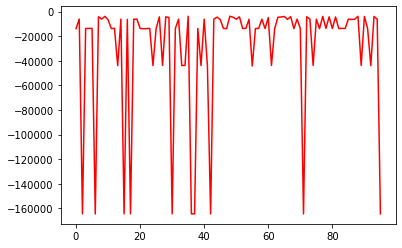

In [14]:
fig, ax = plt.subplots() #calculate_K2score_mean
#ax.plot(calculate_BICscore_mean, color = 'g', label = "Bayesian graph 1")
ax.plot(calculate_BICscore_mean, color = 'r', label = "Bayesian graph 1")

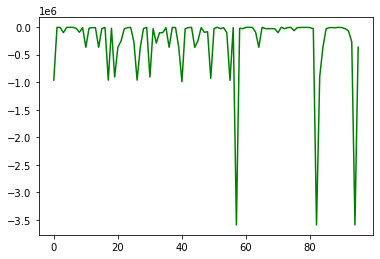

In [38]:
fig, ax = plt.subplots() #calculate_K2score_mean
np.where(calculate_BICscore_mean < -1e4, -1e4, calculate_BICscore_mean)
#calculate_BICscore_mean[calculate_BICscore_mean>1e4] = 1e4
ax.plot(calculate_BICscore_mean, color = 'g', label = "Bayesian graph 1")
#ax.plot(calculate_K2score_mean, color = 'r', label = "Bayesian graph 1")

In [15]:
ind

array([26, 79, 28, 51, 72,  9, 48, 88, 65, 90, 35, 67, 93, 77,  7])

Visuallize the top5 Bayesian graph

493
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1    1    2    1   11    1    1
1      1    1    1    1    1   11    1    1
2      1    1    1    1    1    1    1    1
3      2    1    2   12    1    2    1    2
4      1    1   11    2    1   11    1    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1    1    1    1    1    1    1
996   11    1    1    1    1    1    1    1
997    1    1   11    1    1    1    1    1
998    1    1    1    1    1    1    1    1
999    1    1    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


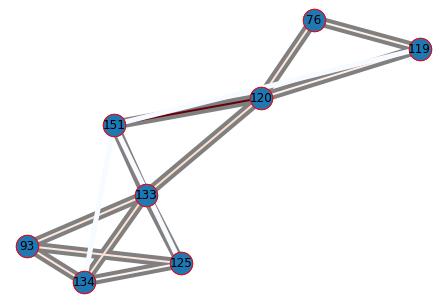

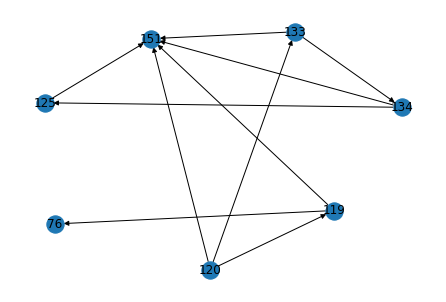

495
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1   11    1    1   11    1   11
1      1    1    1    1    1    1    1    1
2      1   11    1    1    1    1    1    1
3      1    1    1   11    1    1    1    1
4      1    1    1    1   11    1    1    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1   11    1    1    1    1    1
996    1   11    1   11    1    1    1    1
997    1    1    1    1    1    1    1    1
998    1    1    1    1    1    1    1    1
999    1    1    1    1   11    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


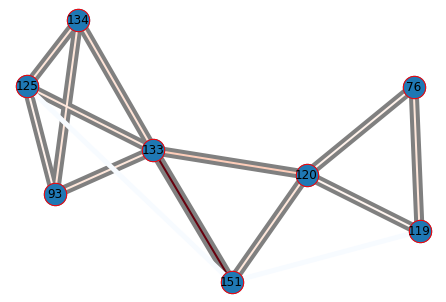

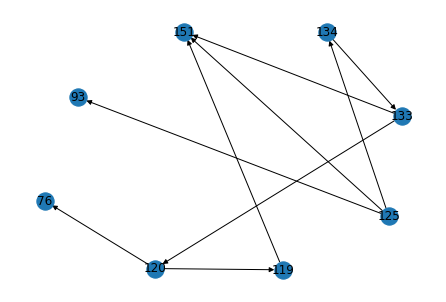

512
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1    1    1    1    1    1    1
1      1    1    1    1    1    1    1    1
2      1    1    1    1   11    1    1    1
3      1    1   11    1    1    1    1    1
4      1    2    1    2    2   12    2    2
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1   12    1    1   12    2    2    1
996    1    1    1    1    1   11    1    1
997    1    1    1    1    1    1    1    1
998    1    1    1    1    1    1    1    1
999    1    1    1   11    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '120', '133', '134', '151']
Draw pgm explaination using networkx


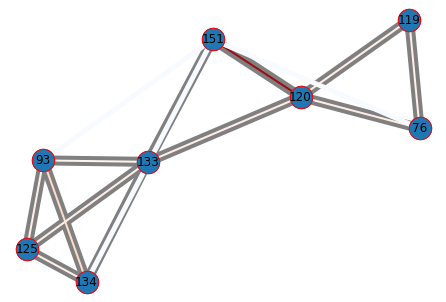

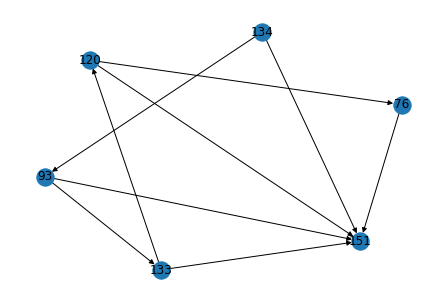

514
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1    1    1    1    1    1    1
1      1    2   11    1    2    2   12    1
2      1    1    1    1    1    1    1    1
3      1    1    1    1    1    1    1    1
4      1    1    1    1    1    1    1    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1    1    1    1    1   11    1
996    2    1    2   12    1    1    1    2
997    1    1    1    1    1    1    1    1
998   11    1    1    1    1    1    1    1
999    1    1    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['93', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


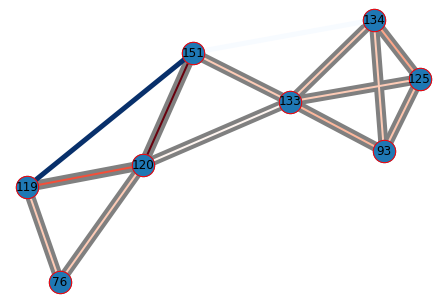

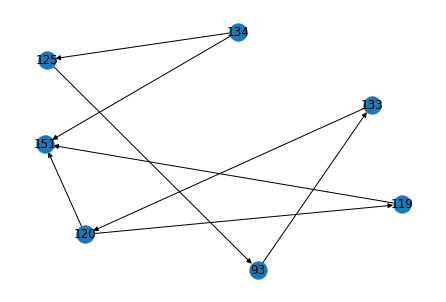

521
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0     11    1    1    1    1    1    1    1
1      1    1   11    1    1    1   11    1
2      1   11    1    1    1    1    1    1
3      1    1    1    1    1    1    1    1
4      1    1    1    1    1    1   11    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1    1    1    1    1   11    1
996    1    1    1    1    1    1    1    1
997    1    1    1    1    1    1    1   11
998    1    1    1    1    1    1    1    1
999    1    1    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


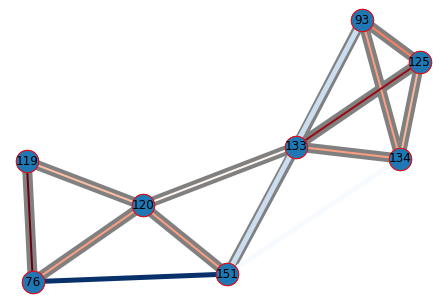

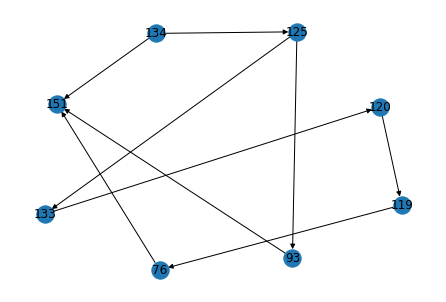

534
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1   11    1    1    1    1    1
1     11    1    2    2    1    1    1    1
2      1    1    1   11    1    1    1    1
3      1    1    1    1   11    1    1    1
4      1    1    1    1    1    1    1    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1    1    1    1    1    1    1
996    1    1    1    1    1    1    1    1
997   11    1    1    1    1    1    1    1
998    1    1    1    1    1    1    1   11
999    1   11    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


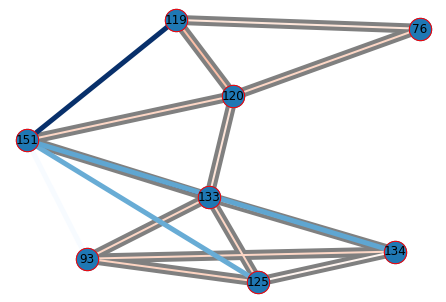

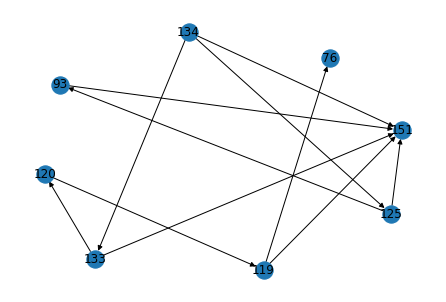

537
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1    1   11    1    1    1    1
1     11    1   11    1    1    1    1   11
2      1    1    1    1    1    1    1    1
3      1    1    1    1    1    1    1    1
4     11    1    1    2    1    1    1   11
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1   11    1    1    1    1    1    1
996    1    1    1    1    1    1    1   11
997   11    1   11   11   11    1    2    1
998    1    1    1    1    1    1    1    1
999    1    1   11    1    1    1    1   11

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '125', '133', '151']
Draw pgm explaination using networkx


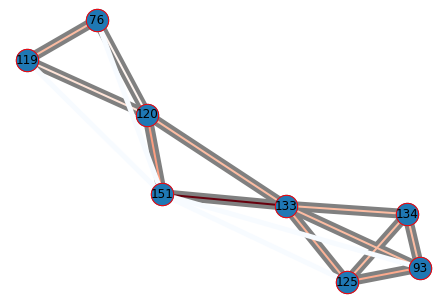

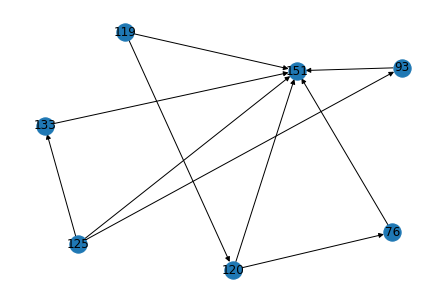

551
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1    1    1    1    1    1    1
1     11    1    2    2    1    1    1    1
2      1    1    1    1    1    1    1    1
3      1    1    1    1    1    1    1    1
4      1   11    1    1    1    1    1    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1    1   11    1    1    1    1
996    1   11    1   11    1    1    1    1
997    1    2    1    1   12    2    2    1
998    1    1    1    1    1    1    1   11
999   12    1    2    2    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['93', '119', '120', '133', '134', '151']
Draw pgm explaination using networkx


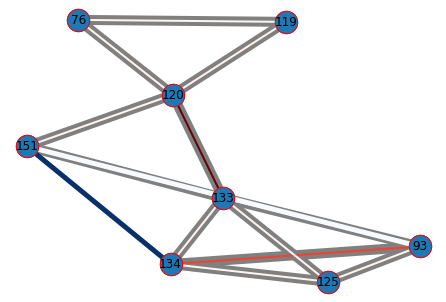

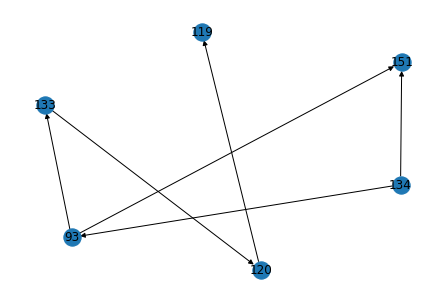

553
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1    1    1    1    1    1    1
1      1    1    1    1    1    1    1   11
2      1    1   11    1    1    1    1    1
3      1   11    1    1    1    1    2    1
4      1    1    1    1    1    1    1    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1    1    1    1    1    1    1
996   11    1    1    1    1    1    1    1
997    1    1    1    1    1    1    1    1
998    1   11    1   12    1   11    1    2
999    1    1    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '133', '134', '151']
Draw pgm explaination using networkx


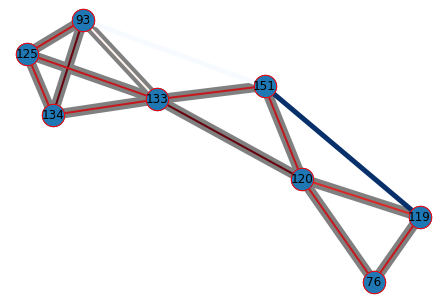

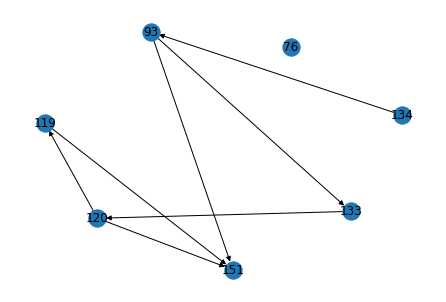

558
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1    1    1   11    1    1    1
1      1    1   11    1    1    1    1    1
2      1    1    1    1    1    1    1    1
3      1    1    1    1    1    1   11    1
4      1   11    1   11    1    1    1    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995   11   11    1    1    1    1    1    1
996    1    1   11    1    1    1    1    1
997    1    1    1    1    1    1   12    1
998    1   11    1    1    1    1    2   11
999    1    1    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


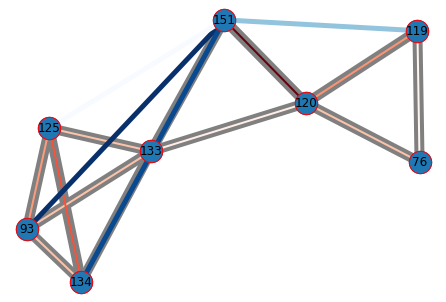

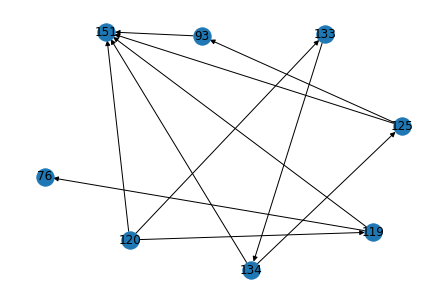

563
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1    1    1    1    1   11    1
1      1   11   12   12    1    1    1    1
2      1   12    1   11    2    2   12    1
3      1   11    1    1    1    1    1    1
4      1    1    1    2    1   11    2    2
..   ...  ...  ...  ...  ...  ...  ...  ...
995    2    1    2   12   11    2    1    2
996   11    1    1    2    1   11    1   11
997    1    1    1    1    1    1    1    1
998    1    1    1    1   11    1    1   11
999   11    1    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


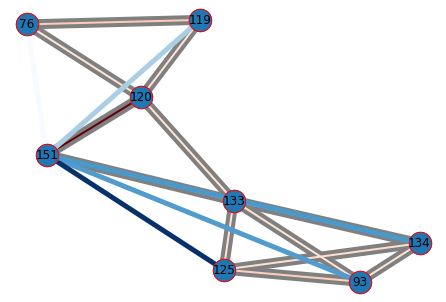

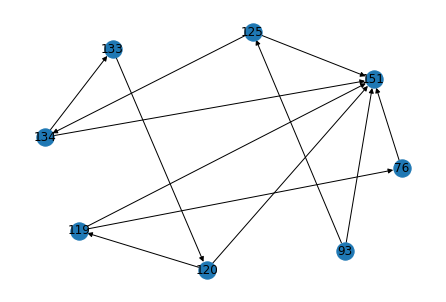

565
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1   11    1    1    1    1    1    1
1      1    1    1    1    1    1    1    1
2      1    1    1    1   11    1    1    1
3      1    2    1    2    2   12    2    2
4      1    1    1    1    1    1    1    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1    2   12    1    1    1    1
996    1   12    1    2    2   12    2    2
997    1   11    1    1    1    1    2    1
998    1    1   11    1    1    1    1    1
999    1    1    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


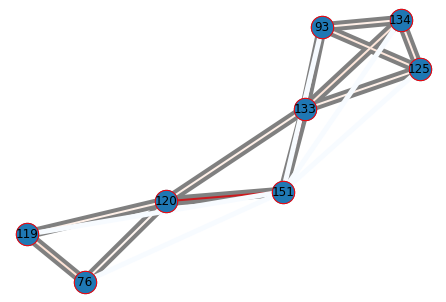

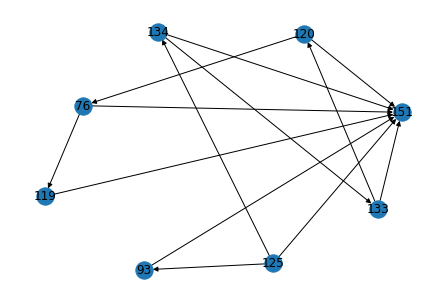

574
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    2    1    1    2    2   12    1
1      1    1    1    1    1    1    1    1
2      1    1    1    1    1    1    1    1
3      1    1    1    1    1    1    1   11
4      1    2    2   12    2    2   12    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1    1    1    1    1   11    1
996    1    1    1    1    1    1    1    1
997   12    1    2    2    1    1    1    1
998    1    1    1    1    1    1    1    1
999    1   11    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['93', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


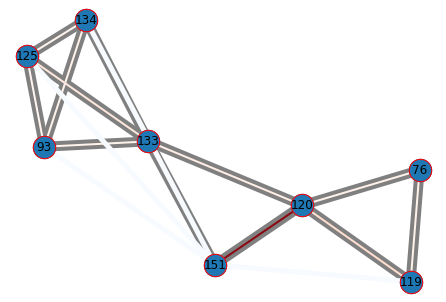

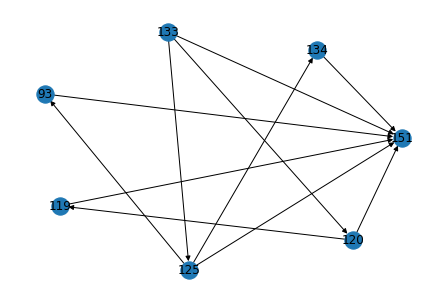

576
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    1    1    1    1   11    1    1
1      1    1    1    1    1    1   12    1
2      1    1    1    1    1    1    1    1
3      1    1    1   11    1    1    1    1
4      1   12    1    1    2    2   12    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    2    1    2   12   12    2   12
996   12    1    2    2    1    1    1   11
997    2    1    2   12    1    1    1    2
998    1    1    1    1    1    1    1    1
999    1    1    1    1   11   11    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '125', '133', '151']
Draw pgm explaination using networkx


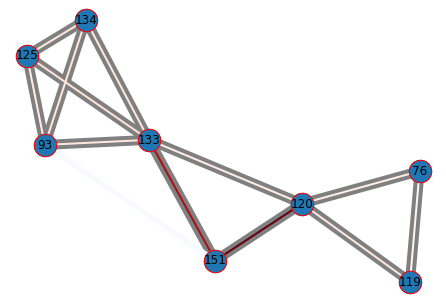

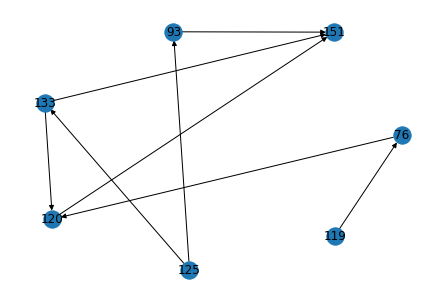

579
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
data is:       76   93   119  120  125  133  134  151
0      1    2    1    1   12    2    2    1
1      1    1    1    1    1    1    1    1
2      1    1    1    1    1    1    1    1
3      1   11    1    1    1    1    1    1
4      1    1    1    1    1    1   11    1
..   ...  ...  ...  ...  ...  ...  ...  ...
995    1    1    1    1    1    1    1    1
996    1   11    1    1    1    1    1    1
997    1    1    1    1    1    1    1    1
998    1    1    1    1    1    1    1    1
999    1    1    1    1    1    1    1    1

[1000 rows x 8 columns]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['76', '93', '119', '120', '125', '133', '134', '151']
Draw pgm explaination using networkx


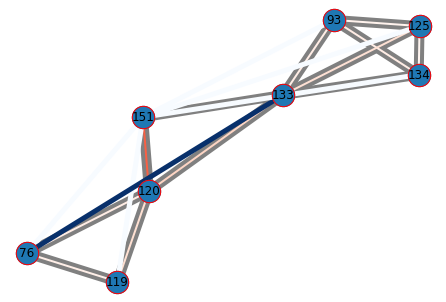

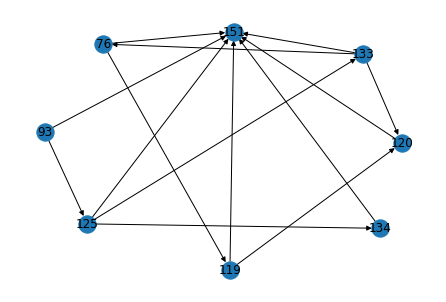

In [16]:
samples = 0
end = 581
start = end - 96  + 1
ind_new = ind + start


for val_features, val_labels in dm.val_dataloader():
    samples = samples + 1
    
    if samples in ind_new:
        print(samples)
        #print("node: ", i)
        inputs = val_features
        batch_size, seq_len, num_nodes = inputs.shape
        assert input_dim == num_nodes

        dependent_neighbors = []
        for probe_snapshot in range(11,12):

            hidden_state = torch.zeros(batch_size, num_nodes * hidden_dim).type_as(inputs)
            output = None
            for i in range(probe_snapshot):
                if i == probe_snapshot - 1:
                    dest_model = models.tgcn.TGCNCell_clone(adj, input_dim, hidden_dim, hidden_state)
                    dest_model.eval()    
                    clone_layers = []
                    for item in source_task.model.tgcn_cell._modules.items():
                        clone_layers.append(item[0])

                    for layer in clone_layers:
                        if hasattr(getattr(dest_model, layer), 'weights'):
                            with torch.no_grad():
                                getattr(dest_model, layer).weights.copy_(getattr(source_model, layer).weights)
                        if hasattr(getattr(dest_model, layer), 'biases'):
                            with torch.no_grad():
                                getattr(dest_model, layer).biases.copy_(getattr(source_model, layer).biases)

                output, hidden_state = source_model(inputs[:, i, :], hidden_state) 

            input_features = inputs[:, probe_snapshot-1, :]
            # Init
            explainer = Node_Explainer(dest_model, dest_task, adj, input_features[0], 0, 2)
            # Explain
            pgm_nodes, data, pgm_stats = explainer.explain_tgcn_node(TARGET_NODE, 5e-3, 0.1, 1000, 0.01)#0.01, 0.1, 1000, 0.01)
            
            print("data is: ", data)
            
            print("Generate the PGM")
            pgm_explanation = explainer.pgm_generate(TARGET_NODE, data, stats, pgm_nodes)
            
            nA = explainer.n_hops_A(2)
            node_idx_new, sub_A, sub_X, neighbors = explainer.extract_n_hops_neighbors(nA,TARGET_NODE)
            plot_G = graph_from_adj(sub_A)
            label_dict = dict(zip(range(len(neighbors.tolist())),neighbors.tolist()))

            pos=nx.spring_layout(plot_G)
            print("PGM_explainer nodes: ", pgm_explanation.nodes())

            edge_strength = {}
            
            for u,v in pgm_explanation.edges(): 

                node_list_rm_v = [node for node in pgm_explanation.nodes() if node!= v]
                s = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_v)
                node_list_rm_u = [node for node in pgm_explanation.nodes() if( node!= v and node !=u )]
                su = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_u)
                edge_strength[(u,v)] = s - su


            edge_weight = {}
            for plot_edge in list(plot_G.edges()):
                edge_key = (str(label_dict[plot_edge[0]]),str(label_dict[plot_edge[1]]))
                plot_key = (plot_edge[0],plot_edge[1])
                edge_weight[plot_key] = 0
                if edge_key in edge_strength.keys():
                    edge_weight[plot_key] = edge_strength[edge_key]
                edge_key_rev = (str(label_dict[plot_edge[1]]),str(label_dict[plot_edge[0]]))
                if edge_key_rev in edge_strength.keys():
                    edge_weight[plot_key] = edge_strength[edge_key_rev]
            inv_label_dict = dict(zip(neighbors.tolist(),range(len(neighbors.tolist()))))

            pgm_only_edges = []

            for edge_key in edge_strength.keys():
                plot_key = (inv_label_dict[int(edge_key[0])], inv_label_dict[int(edge_key[1])])
                rev_plot_key = (inv_label_dict[int(edge_key[1])], inv_label_dict[int(edge_key[0])])
                if plot_key not in list(plot_G.edges()):
                    if rev_plot_key not in list(plot_G.edges()):
                        pgm_only_edges.append(plot_key)
                        edge_weight[plot_key] = edge_strength[edge_key]
            
            plt.figure()
            print("Draw pgm explaination using networkx")

            nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

            edges = nx.draw_networkx_edges(plot_G,
                                       pos=pos,
                                       edgelist = plot_G.edges(),
                                       edge_color=[edge_weight[e] for e in plot_G.edges()],
                                       edge_cmap= plt.cm.Reds,
                                       alpha=1.0,
                                       width = 2)

            nodes = nx.draw_networkx_nodes(plot_G, pos, node_size=500)
            nodes.set_edgecolor('red')



            edges = nx.draw_networkx_edges(plot_G,
                                           pos=pos,
                                           edgelist =pgm_only_edges,
                                           edge_color=[edge_weight[e] for e in pgm_only_edges],
                                           edge_cmap= plt.cm.Blues,
                                           alpha=1.0,
                                           width = 5)
            
            plt.figure()
            nx.draw(pgm_explanation, with_labels=True)
            plt.show()

            #path = "bayesian_data/node_" + str(TARGET_NODE) + "/data_" +  str(samples) + ".csv"
            #data.to_csv(path)
    #         for i in range(len(first_hop )):
    #             ScoreClass = K2Score(data)
    #             template_model = BayesianModelList1[i]
    #             calculate_score_first[i].append(ScoreClass.local_score(TARGET_NODE,template_model.predecessors(TARGET_NODE)))
    #         for i in range(len(second_hop )):
    #             ScoreClass = K2Score(data)
    #             template_model = BayesianModelList2[i]
    #             calculate_score_second[i].append(ScoreClass.local_score(TARGET_NODE,template_model.predecessors(TARGET_NODE)))




In [17]:
ind

array([26, 79, 28, 51, 72,  9, 48, 88, 65, 90, 35, 67, 93, 77,  7])

BIC score

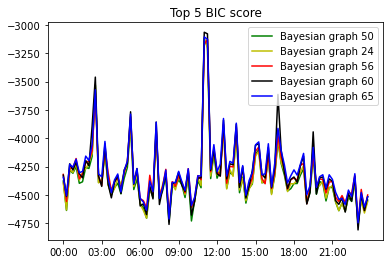

In [19]:
import sklearn, math,csv
import matplotlib.ticker as mticker
d = ['{0:02d}:{1:02d}'.format(int((i*15)/60), (i*15)%60) for i in range(96)]
# helper function for the formatter
def listifed_formatter(x, pos=None):
    try:
        return d[int(x)]
    except IndexError:
        return ''
mt = mticker.FuncFormatter(listifed_formatter)

fig, ax = plt.subplots()

# ax.plot( calculate_BICscore[ind[0]], color = 'g', label = "Bayesian graph 50")
# ax.plot( calculate_BICscore[ind[1]], color = 'y', label = "Bayesian graph 24")
# ax.plot( calculate_BICscore[ind[2]], color = 'r', label = "Bayesian graph 56")
# ax.plot( calculate_BICscore[ind[3]], color = 'black', label = "Bayesian graph 60")
# ax.plot( calculate_BICscore[ind[4]], color = 'b', label = "Bayesian graph 65")

ax.plot( calculate_BICscore[ind[0]], color = 'g', label = "Bayesian graph 50")
ax.plot( calculate_BICscore[ind[1]], color = 'y', label = "Bayesian graph 24")
ax.plot( calculate_BICscore[ind[2]], color = 'r', label = "Bayesian graph 56")
ax.plot( calculate_BICscore[ind[3]], color = 'black', label = "Bayesian graph 60")
ax.plot( calculate_BICscore[ind[4]], color = 'b', label = "Bayesian graph 65")

#ax.plot( calculate_BICscore[11], color = 'c', label = "Bayesian graph10")

#     ax.plot( pred_result[(start) : end + 1,j]/20, color = 'b', label = 'Neighbor prediction')    
#     #ax.plot( calculate_score, color = 'black', label = 'edge strength')
#     ax.plot( calculate_score_first_new[count,:] + 2, color = 'y', label = 'Neighobr Bayesian score')
ax.legend()
ax.xaxis.set_major_formatter(mt)   
label_name = 'Top 5 BIC score'
fname = 'bayesian_score/node_' +str(TARGET_NODE)  + '/p1e-3/top5BICScore' + '.png'
plt.xticks(np.arange(0, 96, 12))
plt.title(label_name)
plt.savefig(fname)

K2 Score

In [8]:
file_path = 'bayesian_data/node_' + str(TARGET_NODE) + '/p1e-4/calculate_score.npy'
calculate_K2score = np.load(file_path)
calculate_K2score_sum = np.sum(calculate_K2score, axis = -1)
calculate_K2score_mean = np.mean(calculate_K2score, axis = -1)

top_k = 5
ind = np.argpartition(calculate_K2score_sum, -top_k)[-top_k:]

In [9]:
ind

array([86, 90, 14, 70, 92])

500
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['93', '95', '96', '97', '125', '133', '134', '145']
Draw pgm explaination using networkx


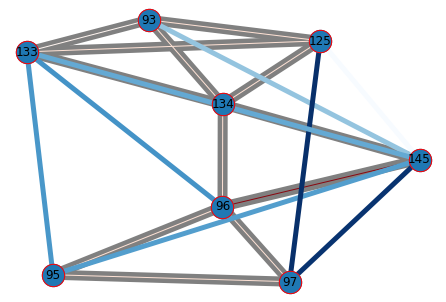

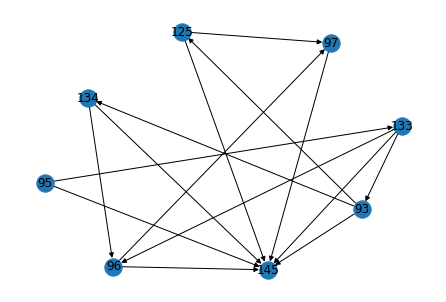

556
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['93', '95', '96', '97', '125', '133', '134', '145']
Draw pgm explaination using networkx


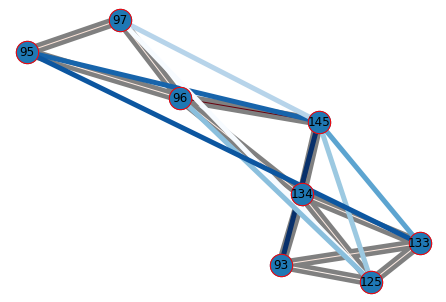

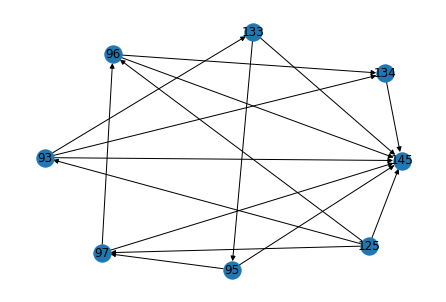

572
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['93', '95', '96', '97', '125', '133', '134', '145']
Draw pgm explaination using networkx


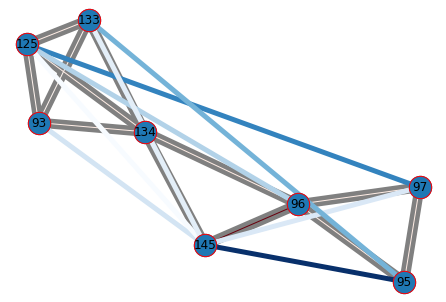

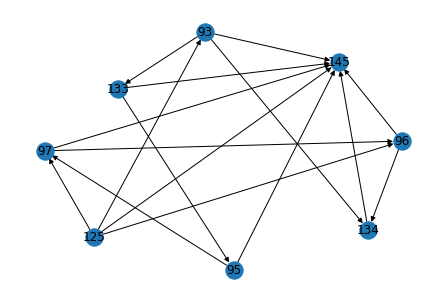

576
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['93', '95', '96', '97', '125', '133', '134', '145']
Draw pgm explaination using networkx


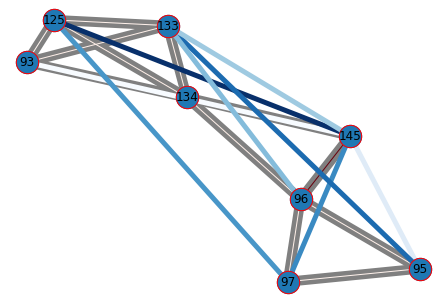

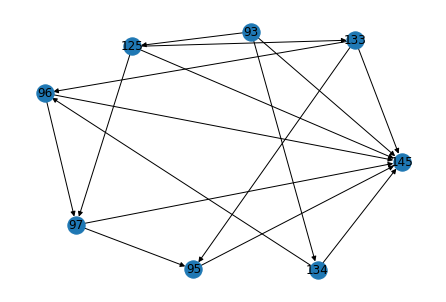

578
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM_explainer nodes:  ['93', '95', '96', '97', '125', '133', '134', '145']
Draw pgm explaination using networkx


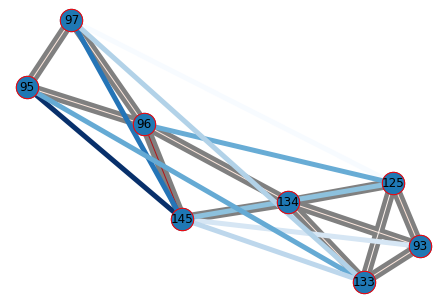

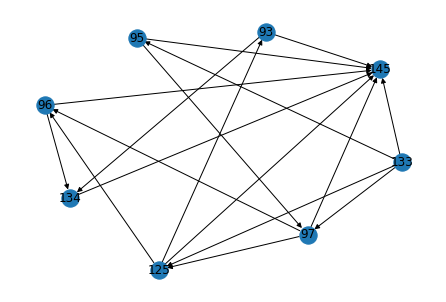

FileNotFoundError: [Errno 2] No such file or directory: 'bayesian_score/node_145/top5K2core.png'

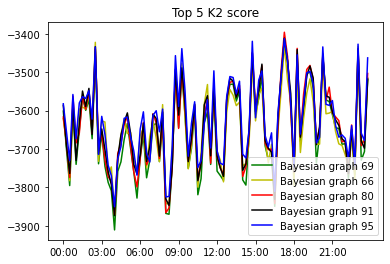

In [11]:
file_path = 'bayesian_data/node_' + str(TARGET_NODE) + '/p1e-4/calculate_score.npy'
calculate_K2score = np.load(file_path)
calculate_K2score_sum = np.sum(calculate_K2score, axis = -1)
top_k = 5
ind = np.argpartition(calculate_K2score_sum, -top_k)[-top_k:]

samples = 0
ind_new = ind + start


for val_features, val_labels in dm.val_dataloader():
    samples = samples + 1
    
    if samples in ind_new:
        print(samples)
        #print("node: ", i)
        inputs = val_features
        batch_size, seq_len, num_nodes = inputs.shape
        assert input_dim == num_nodes

        dependent_neighbors = []
        for probe_snapshot in range(11,12):

            hidden_state = torch.zeros(batch_size, num_nodes * hidden_dim).type_as(inputs)
            output = None
            for i in range(probe_snapshot):
                if i == probe_snapshot - 1:
                    dest_model = models.tgcn.TGCNCell_clone(adj, input_dim, hidden_dim, hidden_state)
                    dest_model.eval()    
                    clone_layers = []
                    for item in source_task.model.tgcn_cell._modules.items():
                        clone_layers.append(item[0])

                    for layer in clone_layers:
                        if hasattr(getattr(dest_model, layer), 'weights'):
                            with torch.no_grad():
                                getattr(dest_model, layer).weights.copy_(getattr(source_model, layer).weights)
                        if hasattr(getattr(dest_model, layer), 'biases'):
                            with torch.no_grad():
                                getattr(dest_model, layer).biases.copy_(getattr(source_model, layer).biases)

                output, hidden_state = source_model(inputs[:, i, :], hidden_state) 

            input_features = inputs[:, probe_snapshot-1, :]
            # Init
            explainer = Node_Explainer(dest_model, dest_task, adj, input_features[0], 0, 2)
            # Explain
            pgm_nodes, data, pgm_stats = explainer.explain_tgcn_node(TARGET_NODE, 0.00001, 0.2, 700, 0.01)#0.01, 0.1, 1000, 0.01)
            
            print("Generate the PGM")
            pgm_explanation = explainer.pgm_generate(TARGET_NODE, data, stats, pgm_nodes)
            
            nA = explainer.n_hops_A(2)
            node_idx_new, sub_A, sub_X, neighbors = explainer.extract_n_hops_neighbors(nA,TARGET_NODE)
            plot_G = graph_from_adj(sub_A)
            label_dict = dict(zip(range(len(neighbors.tolist())),neighbors.tolist()))

            pos=nx.spring_layout(plot_G)
            print("PGM_explainer nodes: ", pgm_explanation.nodes())

            edge_strength = {}
            
            for u,v in pgm_explanation.edges(): 

                node_list_rm_v = [node for node in pgm_explanation.nodes() if node!= v]
                s = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_v)
                node_list_rm_u = [node for node in pgm_explanation.nodes() if( node!= v and node !=u )]
                su = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_u)
                edge_strength[(u,v)] = s - su


            edge_weight = {}
            for plot_edge in list(plot_G.edges()):
                edge_key = (str(label_dict[plot_edge[0]]),str(label_dict[plot_edge[1]]))
                plot_key = (plot_edge[0],plot_edge[1])
                edge_weight[plot_key] = 0
                if edge_key in edge_strength.keys():
                    edge_weight[plot_key] = edge_strength[edge_key]
                edge_key_rev = (str(label_dict[plot_edge[1]]),str(label_dict[plot_edge[0]]))
                if edge_key_rev in edge_strength.keys():
                    edge_weight[plot_key] = edge_strength[edge_key_rev]
            inv_label_dict = dict(zip(neighbors.tolist(),range(len(neighbors.tolist()))))

            pgm_only_edges = []

            for edge_key in edge_strength.keys():
                plot_key = (inv_label_dict[int(edge_key[0])], inv_label_dict[int(edge_key[1])])
                rev_plot_key = (inv_label_dict[int(edge_key[1])], inv_label_dict[int(edge_key[0])])
                if plot_key not in list(plot_G.edges()):
                    if rev_plot_key not in list(plot_G.edges()):
                        pgm_only_edges.append(plot_key)
                        edge_weight[plot_key] = edge_strength[edge_key]
            
            plt.figure()
            print("Draw pgm explaination using networkx")

            nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

            edges = nx.draw_networkx_edges(plot_G,
                                       pos=pos,
                                       edgelist = plot_G.edges(),
                                       edge_color=[edge_weight[e] for e in plot_G.edges()],
                                       edge_cmap= plt.cm.Reds,
                                       alpha=1.0,
                                       width = 1)

            nodes = nx.draw_networkx_nodes(plot_G, pos, node_size=500)
            nodes.set_edgecolor('red')



            edges = nx.draw_networkx_edges(plot_G,
                                           pos=pos,
                                           edgelist =pgm_only_edges,
                                           edge_color=[edge_weight[e] for e in pgm_only_edges],
                                           edge_cmap= plt.cm.Blues,
                                           alpha=1.0,
                                           width = 5)
            
            plt.figure()

            nx.draw(pgm_explanation, with_labels=True)
            plt.show()

            #path = "bayesian_data/node_" + str(TARGET_NODE) + "/data_" +  str(samples) + ".csv"
            #data.to_csv(path)
    #         for i in range(len(first_hop )):
    #             ScoreClass = K2Score(data)
    #             template_model = BayesianModelList1[i]
    #             calculate_score_first[i].append(ScoreClass.local_score(TARGET_NODE,template_model.predecessors(TARGET_NODE)))
    #         for i in range(len(second_hop )):
    #             ScoreClass = K2Score(data)
    #             template_model = BayesianModelList2[i]
    #             calculate_score_second[i].append(ScoreClass.local_score(TARGET_NODE,template_model.predecessors(TARGET_NODE)))


import sklearn, math,csv
import matplotlib.ticker as mticker
d = ['{0:02d}:{1:02d}'.format(int((i*15)/60), (i*15)%60) for i in range(96)]
# helper function for the formatter
def listifed_formatter(x, pos=None):
    try:
        return d[int(x)]
    except IndexError:
        return ''
mt = mticker.FuncFormatter(listifed_formatter)

fig, ax = plt.subplots()

ax.plot( calculate_K2score[ind[0]], color = 'g', label = "Bayesian graph 69")
ax.plot( calculate_K2score[ind[1]], color = 'y', label = "Bayesian graph 66")
ax.plot( calculate_K2score[ind[2]], color = 'r', label = "Bayesian graph 80")
ax.plot( calculate_K2score[ind[3]], color = 'black', label = "Bayesian graph 91")
ax.plot( calculate_K2score[ind[4]], color = 'b', label = "Bayesian graph 95")
#     ax.plot( pred_result[(start) : end + 1,j]/20, color = 'b', label = 'Neighbor prediction')    
#     #ax.plot( calculate_score, color = 'black', label = 'edge strength')
#     ax.plot( calculate_score_first_new[count,:] + 2, color = 'y', label = 'Neighobr Bayesian score')
ax.legend()
ax.xaxis.set_major_formatter(mt)   
label_name = 'Top 5 K2 score'
fname = 'bayesian_score/node_' +str(TARGET_NODE)  + '/top5K2core' + '.png'
plt.xticks(np.arange(0, 96, 12))
plt.title(label_name)
plt.savefig(fname)
    